In [23]:
!pip install kaggle

Cat Vs Dog Image prediction

In [24]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [25]:
!kaggle datasets download bhavikjikadara/dog-and-cat-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0
100% 775M/775M [00:11<00:00, 122MB/s]
100% 775M/775M [00:11<00:00, 69.4MB/s]


In [26]:
#unzipping datasets
!unzip -q /content/dog-and-cat-classification-dataset.zip -d ./dataset

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

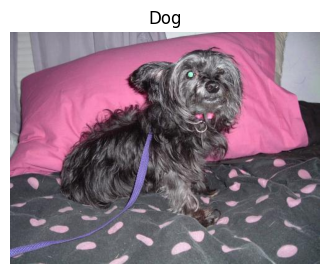

In [28]:
plt.figure(figsize=(4,4))
filepath ='/content/dataset/PetImages/Dog/0.jpg'
image=imread(filepath)
plt.imshow(image)
plt.title('Dog',fontsize=12)
plt.axis('off')
plt.show()

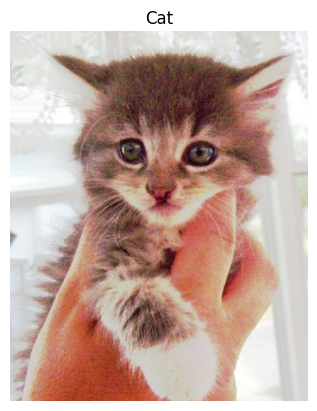

In [29]:
filepath = '/content/dataset/PetImages/Cat/100.jpg'
image=imread(filepath)
plt.imshow(image)
plt.title("Cat",fontsize=12)
plt.axis("off")
plt.show()

In [30]:
import os
import shutil
from pathlib import Path

#define paths
base_dir=Path("/content/dataset/PetImages")
train_dir="/content/dataset/train"
val_dir='/content/dataset/val'

#create directories
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [31]:
#move files (80% train, 20% validation)
for category in ['Cat','Dog']:
  os.makedirs(f'{train_dir}/{category}',exist_ok=True)
  os.makedirs(f'{val_dir}/{category}',exist_ok=True)

  images=list((base_dir/category).glob("*.jpg"))[:5000]
  split=int(0.8 * len(images))

  for img in images[:split]:
    shutil.move(str(img),f"{train_dir}/{category}")

  for img in images[split:]:
    shutil.move(str(img),f"{val_dir}/{category}")

print("Dataset organized into training and validation sets.")

Dataset organized into training and validation sets.


In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
#define image size and batch size
IMG_SIZE = (128,128)
BATCH_SIZE=32

#create imagedatagenerator
train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data=train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data=val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [37]:
model = Sequential([
    #convolutional layers
    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    #second layer
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),

    #flattening
    Flatten(),

    #Fully Connected Layers
    Dense(512,activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])

#compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,511,617 (112.58 MB)

 Trainable params: 29,511,617 (112.58 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
#Train the CNN model
history=model.fit(
    train_data,
    epochs=5,
    validation_data=val_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
  6/250 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.4943 - loss: 2.2082

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.5206 - loss: 0.8391 - val_accuracy: 0.5950 - val_loss: 0.6623
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.5811 - loss: 0.6721 - val_accuracy: 0.6180 - val_loss: 0.6447
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.6328 - loss: 0.6528 - val_accuracy: 0.6920 - val_loss: 0.5985
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.6612 - loss: 0.6241 - val_accuracy: 0.7045 - val_loss: 0.5885
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.6714 - loss: 0.6147 - val_accuracy: 0.7135 - val_loss: 0.5668


In [39]:
#Evaluate on validation data
val_loss,val_acc=model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6946 - loss: 0.5847
Validation Accuracy: 0.71


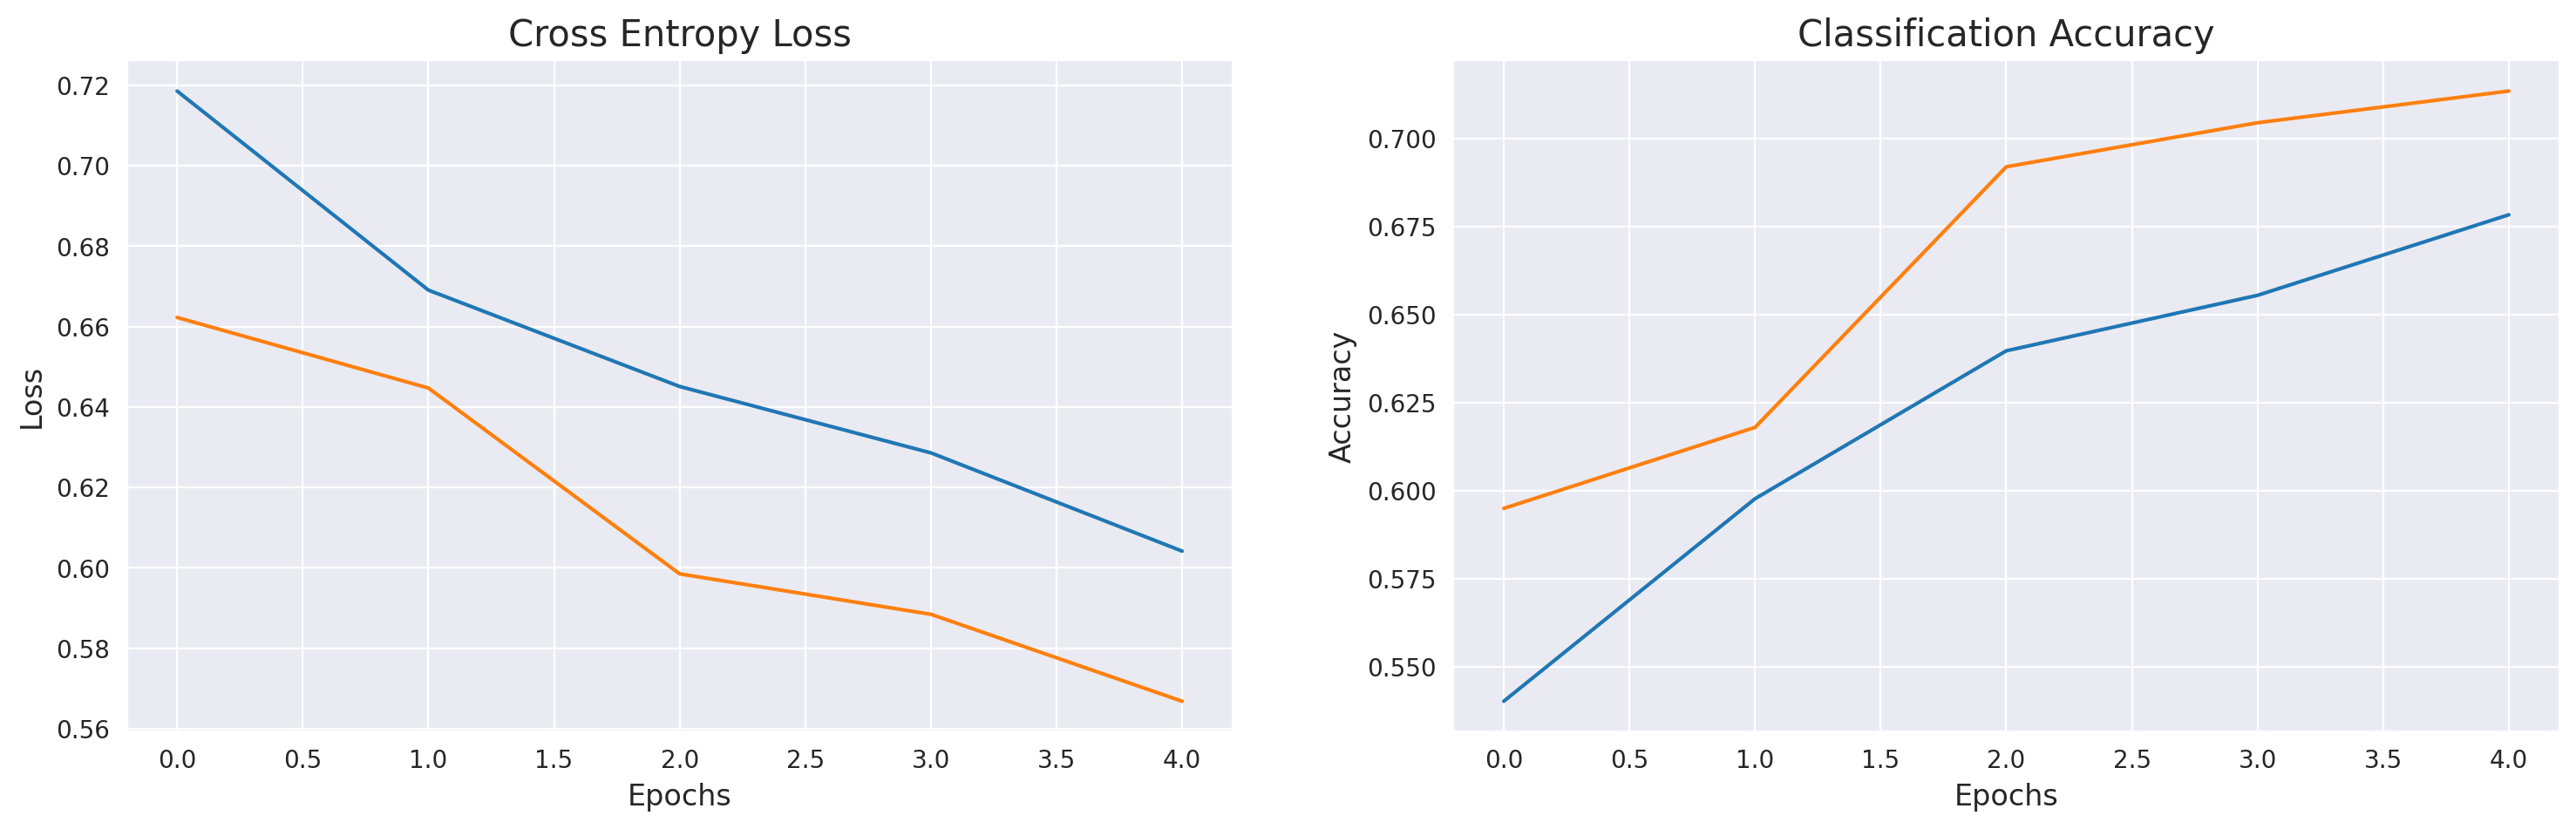

In [40]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []

steps = len(val_data)
for _ in range(steps):
    x, y = next(val_data)
    pred_probs = model.predict(x, verbose=0)
    pred_labels = (pred_probs > 0.5).astype(int).flatten()

    y_true.extend(y.flatten().tolist())
    y_pred.extend(pred_labels.tolist())  # Corrected: append predicted labels

y_true = np.array(y_true, dtype='int')
y_pred = np.array(y_pred, dtype='int')

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[814 186]
 [381 619]]


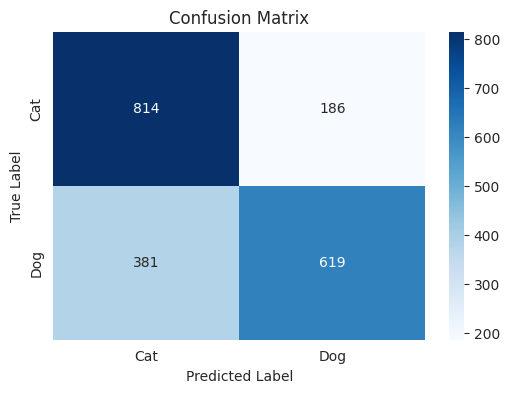

In [46]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [47]:
report = classification_report(y_true,y_pred,target_names=['Cat','Dog'])
print(report)

              precision    recall  f1-score   support

         Cat       0.68      0.81      0.74      1000
         Dog       0.77      0.62      0.69      1000

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.71      2000
weighted avg       0.73      0.72      0.71      2000



In [48]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)  # Changed line
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize # Changed line
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    prediction = model.predict(img_array)[0][0]
    print(prediction)
    label = "Dog" if prediction > 0.5 else "Cat"

    print(f"Prediction: {label} (Confidence: {prediction:.2f})")

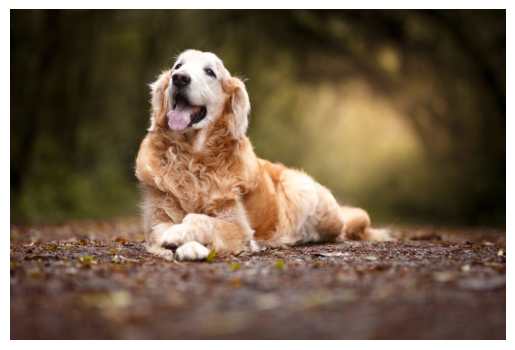

In [49]:
img_path = 'dog.jpg'
image=imread(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [52]:
predict_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
0.5069617
Prediction: Dog (Confidence: 0.51)


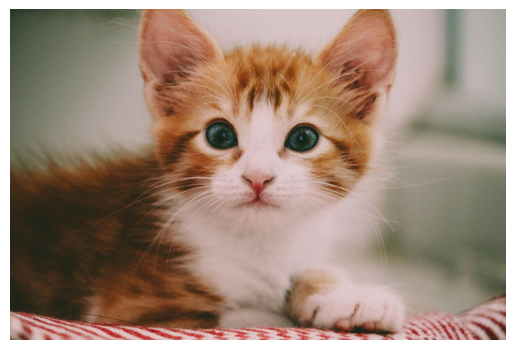

In [53]:
img_path2 = 'cat.jpg'
image2=imread(img_path2)
plt.imshow(image2)
plt.axis('off')
plt.show()

In [54]:
predict_image(img_path2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
0.12222315
Prediction: Cat (Confidence: 0.12)


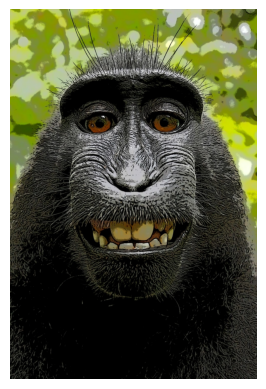

In [55]:
img_path3 = 'monkey.jpg'
image3=imread(img_path3)
plt.imshow(image3)
plt.axis('off')
plt.show()

In [56]:
predict_image(img_path3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.28050655
Prediction: Cat (Confidence: 0.28)
